### About the Dataset
The dataset chosen is the affairs dataset that comes with Statsmodels. It
was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from patsy import dmatrices

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Reading the data
data = sm.datasets.fair.load_pandas().data

In [3]:
display(data.head())
print(data.shape)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


(6366, 9)


The dataset contains 6366 rows and 9 variables:

rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
age: woman's age
yrs_married: number of years married
children: number of children
religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)

educ: level of education (9 = grade school, 12 = high school, 14 = some college, 
16 = college graduate, 17 = some graduate school, 20 = advanced degree)

occupation: woman's occupation (1 = student, 2 = farming/semi- skilled/unskilled, 3 = "white collar", 
4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)

occupation_husb: husband's occupation (same encoding as above)

affairs: time spent in extra-marital affairs

I decided to treat this as a classification problem by creating a new binary
variable affair (did the woman have at least one affair?) and trying to
predict the classification for each woman.

In [4]:
data.rename(columns={"affairs": "affairs_time"}, inplace=True)
data['affair'] = (data.affairs_time > 0).astype(int)

In [5]:
print(data.info())
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affairs_time     6366 non-null   float64
 9   affair           6366 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 497.5 KB
None


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs_time,affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991,1.000000


It seems that there are no missing values in our data.

In [6]:
# def encode_and_bind(original_df, feature_toencode):
#     dummies = pd.get_dummies(original_df[[feature_toencode]])
#     res = pd.concat([original_df, dummies], axis=1)
#     print(res)
#     res = res.drop([feature_toencode], axis=1)
#     return res

In [7]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['occupation','occupation_husb','rate_marriage','religious','educ']]).toarray())
column_name = enc.get_feature_names(['occupation','occupation_husb','rate_marriage','religious','educ'])
enc_df.columns = column_name
enc_df

,occupation_1.0,occupation_2.0,occupation_3.0,occupation_4.0,occupation_5.0,occupation_6.0,occupation_husb_1.0,occupation_husb_2.0,occupation_husb_3.0,occupation_husb_4.0,occupation_husb_5.0,occupation_husb_6.0,rate_marriage_1.0,rate_marriage_2.0,rate_marriage_3.0,rate_marriage_4.0,rate_marriage_5.0,religious_1.0,religious_2.0,religious_3.0,religious_4.0,educ_9.0,educ_12.0,educ_14.0,educ_16.0,educ_17.0,educ_20.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6362,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6363,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6364,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# enc_data = data.join(enc_df)
# enc_data.drop(columns=['occupation','occupation_husb','rate_marriage','religious','educ','affairs_time'], inplace=True)

In [11]:
# enc_data

In [13]:
# enc_data[enc_data['affair']==0].shape

In [14]:
# enc_data[enc_data['affair']!=0].shape

In [135]:
# enc_data = enc_data.loc[:, enc_data.columns != 'affairs_time']

In [136]:
# for i in range(len(data.columns)):
#     feature = data[data.columns[i]]
#     outcome = data['affair']
#     f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,4))
#     sns.scatterplot(feature, outcome, ax=ax1, color='g')
#     sns.boxplot(feature, ax=ax2, color='m')
#     sns.distplot(feature, ax=ax3, color='r')

In [15]:
# fig, ax = plt.subplots(figsize=(15,10))  
# box_plot = sns.boxplot(data=enc_data, width= 0.5,ax=ax,  fliersize=4)
# plt.xticks(rotation=90)
# plt.show()

> Check if rate_marriage outlier is okay to proceed? Also children outlier?\
> children outlier !!

In [17]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data[['age','yrs_married','children']])

In [20]:
scaled_df

array([[ 0.42602474, -0.00129473,  1.11844056],
       [-0.3041854 ,  0.54818992,  1.11844056],
       [-1.03439554, -0.8942073 , -0.97454634],
       ...,
       [-1.03439554, -0.8942073 , -0.97454634],
       [ 0.42602474, -0.41340822, -0.27688404],
       [-1.03439554, -0.8942073 , -0.97454634]])

In [21]:
processed_data = np.concatenate([scaled_df, enc_df], axis=1)
processed_data

array([[ 0.42602474, -0.00129473,  1.11844056, ...,  0.        ,
         1.        ,  0.        ],
       [-0.3041854 ,  0.54818992,  1.11844056, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03439554, -0.8942073 , -0.97454634, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.03439554, -0.8942073 , -0.97454634, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.42602474, -0.41340822, -0.27688404, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03439554, -0.8942073 , -0.97454634, ...,  1.        ,
         0.        ,  0.        ]])

In [25]:
processed_data

array([[ 0.42602474, -0.00129473,  1.11844056, ...,  0.        ,
         1.        ,  0.        ],
       [-0.3041854 ,  0.54818992,  1.11844056, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03439554, -0.8942073 , -0.97454634, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.03439554, -0.8942073 , -0.97454634, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.42602474, -0.41340822, -0.27688404, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03439554, -0.8942073 , -0.97454634, ...,  1.        ,
         0.        ,  0.        ]])

In [30]:
X = processed_data
y = np.array(data['affair'])

In [31]:
X

array([[ 0.42602474, -0.00129473,  1.11844056, ...,  0.        ,
         1.        ,  0.        ],
       [-0.3041854 ,  0.54818992,  1.11844056, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03439554, -0.8942073 , -0.97454634, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.03439554, -0.8942073 , -0.97454634, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.42602474, -0.41340822, -0.27688404, ...,  0.        ,
         0.        ,  0.        ],
       [-1.03439554, -0.8942073 , -0.97454634, ...,  1.        ,
         0.        ,  0.        ]])

In [32]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 


vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(scaled_df,i) for i in range(scaled_df.shape[1])]
vif["Features"] = ['age','yrs_married','children']

In [42]:
vif

,vif,Features
0,5.002602,age
1,6.779777,yrs_married
2,2.491762,children


> yrs_married and age has correlation

In [43]:
X = X
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 355)

In [44]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [45]:
y_pred = log_reg.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [46]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.7229899497487438

In [47]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[960, 124],
       [317, 191]])

In [48]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [49]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.7229899497487438

In [50]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.8856088560885609

In [51]:
# Recall 
Recall = true_positive/(true_positive+false_negative)
Recall

0.7517619420516837

In [52]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.8132147395171538

In [53]:
# Area Under Curve
auc = roc_auc_score(y_test, y_pred)
auc

0.6307965540285325

**ROC**

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(roc_curve(y_test, y_pred))

(array([0.        , 0.11439114, 1.        ]), array([0.        , 0.37598425, 1.        ]), array([2, 1, 0]))


In [55]:
thresholds

array([2, 1, 0])

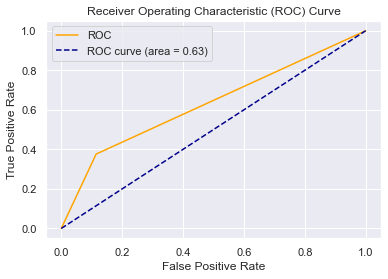

In [56]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()